In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

from nonlocalunet.models import NonLocalUnet
from liverfiles.metrics import dr_score, mhd_score
from liverfiles.Trainer import Trainer
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from liverfiles.loader import Ds

import random

# Data

In [2]:
pathes = []
for (dirpath, dirnames, filenames) in os.walk('data'):
    if dirpath == os.path.join('data\segmentations'):
        continue
    pathes.extend([os.path.join(dirpath, i)for i in filenames] )
df = pd.DataFrame({'path': pathes})
df['id'] = df.path.str.split(os.path.sep).str[-1].str[7:-4]
df.id = df.id.astype('int16')
df = df.sort_values(by='id').reset_index(drop=True)

# Dataloader

In [3]:
shape = (8, 8, 8)

train_ds = Ds(df[:10], shape, None)
val_ds = Ds(df[-10:], shape, None)
train_dl = DataLoader(train_ds,
                      batch_size=5,
                      shuffle=True,
                      num_workers=0,
                      pin_memory=False,
                      drop_last=True)
val_dl = DataLoader(val_ds,
                     batch_size=1,
                     shuffle=False,
                     num_workers=1,
                     pin_memory=False,
                     drop_last=False)
#test1, test2 = next(iter(train_dl))

# Visualization

In [15]:
a, b = next(iter(train_dl))
c = 0

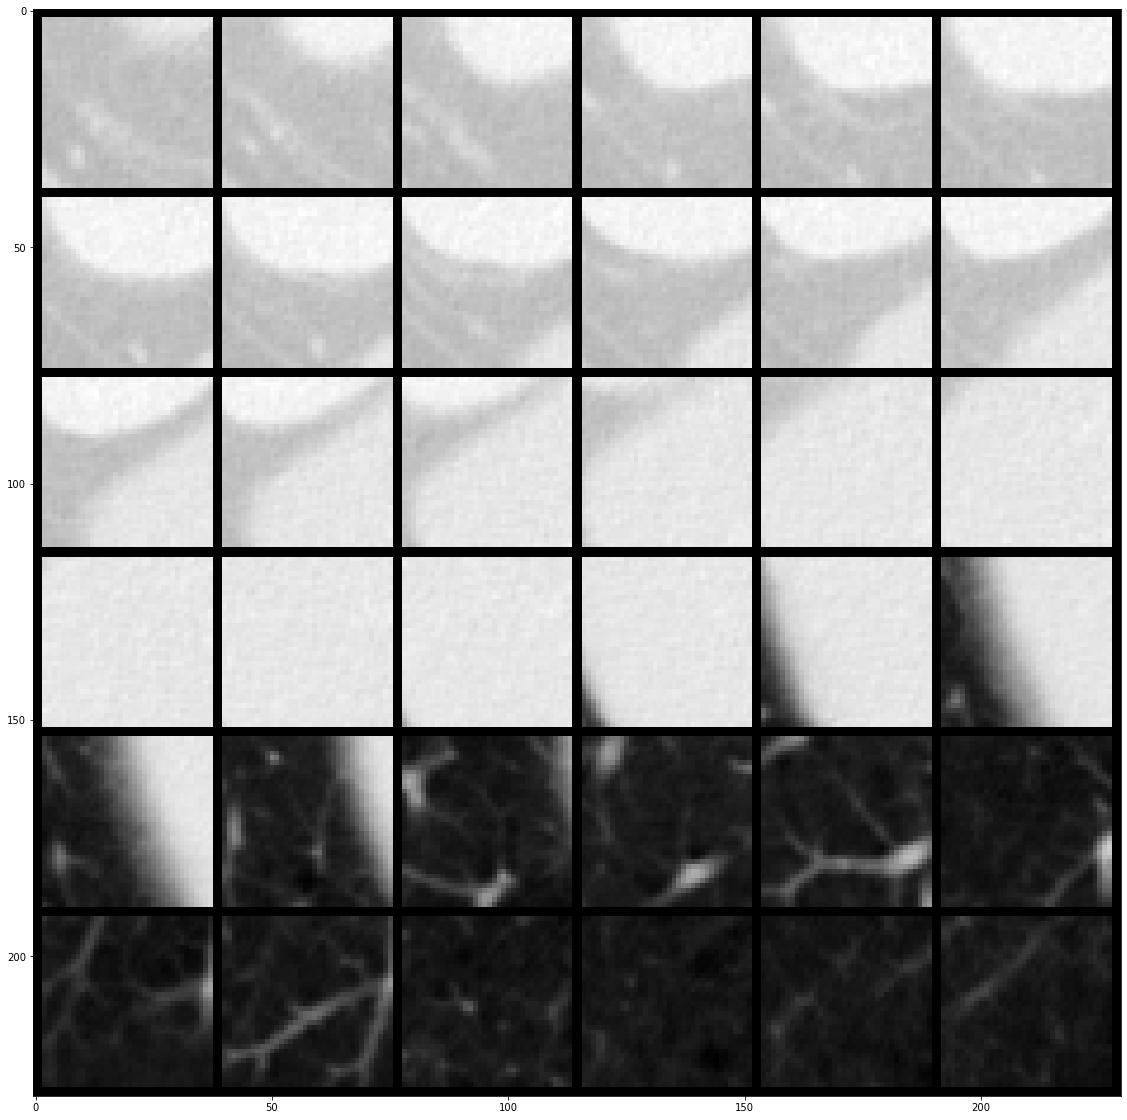

In [16]:
example = torchvision.utils.make_grid(torch.transpose(a[c], 0,1), nrow=6)
plt.figure(figsize=(20,20))
plt.imshow(example.permute(1,2,0))

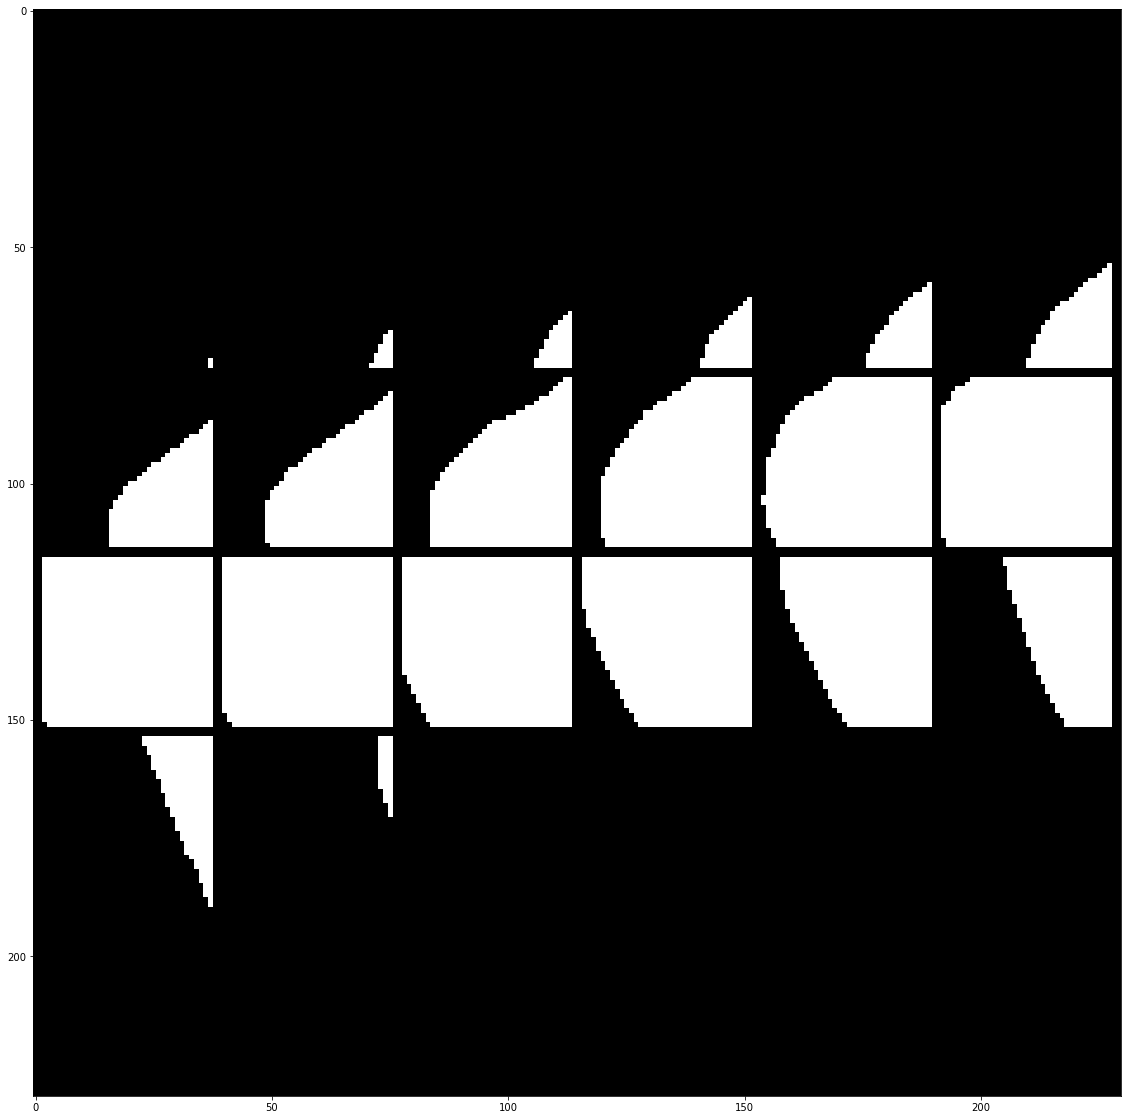

In [17]:
example = torchvision.utils.make_grid(torch.transpose(b[c], 0,1)[:,0:1,:,:].float(), nrow=6)
plt.figure(figsize=(20,20))
plt.imshow(example.permute(1,2,0))
c+=1

# Model

In [4]:
model = NonLocalUnet(1, 2).to('cuda')
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.BCELoss()
device = 'cuda'

In [5]:
trainer = Trainer(model, optimizer, scheduler, criterion, train_dl, val_dl, device, 'unet_test', 'kek')

wandb: Currently logged in as: aykhan (use `wandb login --relogin` to force relogin)


In [6]:
trainer.train(10)

AttributeError: 'Trainer' object has no attribute 'get_target'

In [ ]:
class Liver(pl.LightningModule):
    def __init__(self, model, loss):
        super().__init__()
        self.model = model
        self.dice = DiceLoss()
        self.bce = nn.BCELoss()
        
    def forward(self, x):
        return self.model(x.float())
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.model(x.float())
        bce_loss = self.bce(preds, y.float())
        dice_loss = self.dice(preds, y.float())
        loss = bce_loss + 0.5*dice_loss
        self.log('train_bce', bce_loss)
        self.log('train_dice', dice_loss)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.model(x.float())
        bce_loss = self.bce(preds, y.float())
        dice_loss = self.dice(preds, y.float())
        loss = bce_loss + 0.5*dice_loss
        self.log('test_bce', bce_loss)
        self.log('test_dice', dice_loss)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
model = NonLocalUnet(1, 2)
logger = TensorBoardLogger('tb_logs', name='my_model')
ligth = Liver(model, DiceLoss())
trainer = pl.Trainer(gpus=1, logger=logger)
trainer.fit(ligth, train_dl, test_dl)

In [ ]:
res = ligth(a.float())

In [ ]:
plt.imshow(b[2,0,31].detach())

Problem: 49